In [1]:
%matplotlib notebook
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append('../')
import barycenter
from scipy.spatial.distance import cdist

In [2]:
def make_1D_gauss(n, m, s, normalize=True):
    x = np.arange(n, dtype=np.float64)
    h = np.exp(-(x - m)**2 / (2 * s**2))
    if normalize:
        h = h / h.sum()         
    return h

def dist(n):
    x = np.arange(n, dtype=np.float64).reshape((n, 1))
    res = cdist(x, x, metric='sqeuclidean')
    return res

In [3]:
#
# Generate data
# -------------

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
means = np.array([20, 30, 70])
stds = np.array([2, 5, 2])
gaus_hist = []
gaus_hist_unnorm = []

weights = np.array([1.0, 1.0, 2.0])
weights = weights / np.sum(weights)

for m, s in zip(means, stds):
    g = make_1D_gauss(n, m=m, s=s) + 1e-100  # m= mean, s= std
    gaus_hist.append(g)
    gaus_hist_unnorm.append(make_1D_gauss(n, m=m, s=s, normalize=False))   

# creating matrix A containing all distributions
A = np.vstack(gaus_hist).T
A_unnorm = np.vstack(gaus_hist_unnorm).T

n_distributions = A.shape[1]

# distance matrix + normalization
D = dist(n)
D /= D.max()

<IPython.core.display.Javascript object>


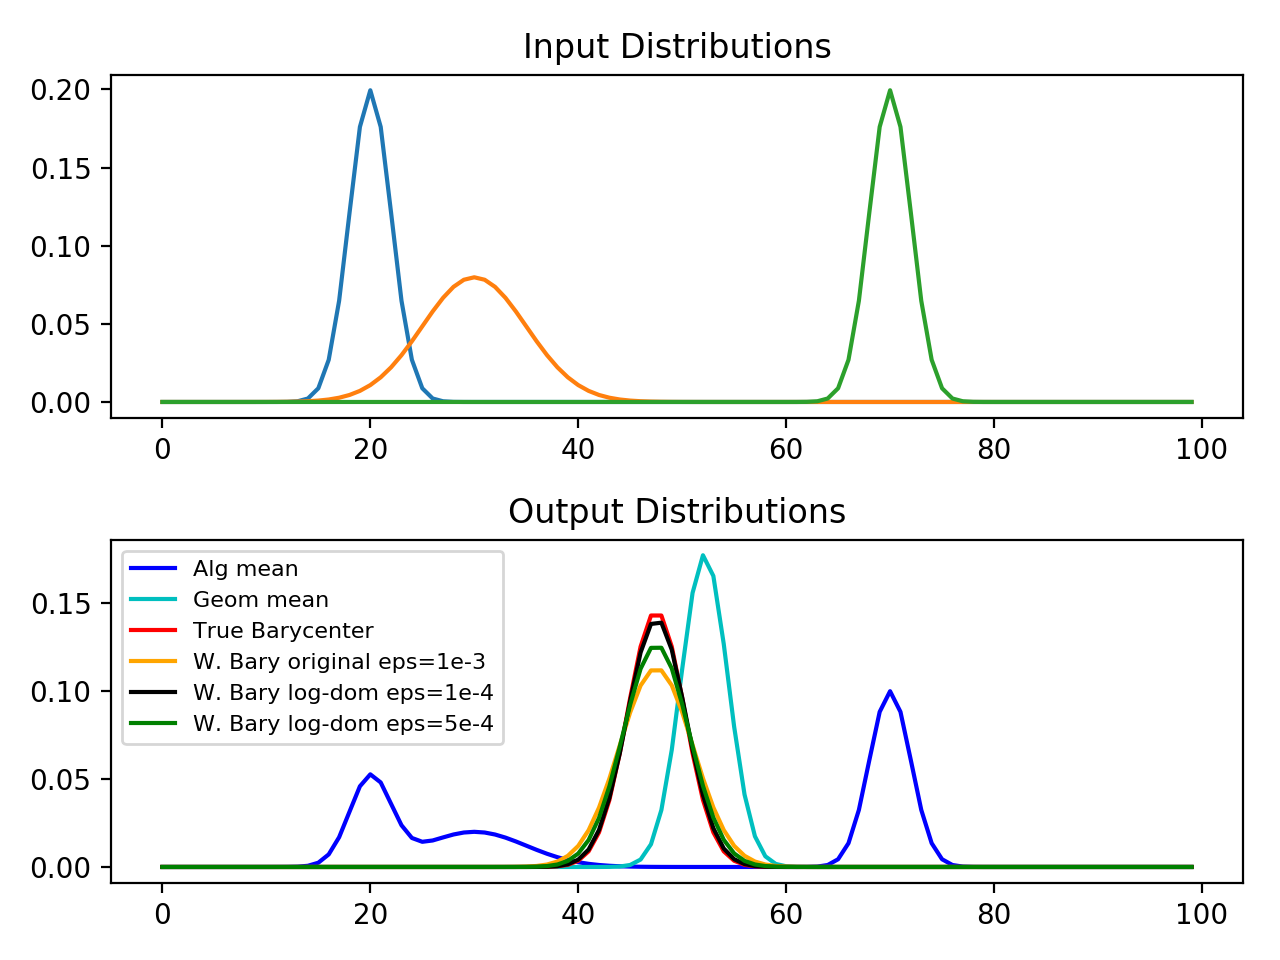

In [4]:
# ------ Algebraic mean -------
alg_mean = A.dot(weights)

# ------ Geometric mean -------
log_ = np.log(A)
geom_mean = np.exp(np.dot(weights.reshape(1,-1), log_.T)).squeeze()
geom_mean = geom_mean / np.sum(geom_mean)

# --- True Guassian barycenter ------
# Theorem 2.4 in https://arxiv.org/pdf/1511.05355.pdf
var_bary = 1
while(True):
    var_bary_new = 0
    
    for w, s in zip(weights, stds):
        var_bary_new += w*np.sqrt(var_bary)*s
        
    if var_bary_new - var_bary < 1e-7:
        var_bary = var_bary_new
        break
    else:
        var_bary = var_bary_new

std_bary = np.sqrt(var_bary)
mean_bary = np.sum(weights * means)

true_gauss_bary = make_1D_gauss(n, m=mean_bary, s=std_bary)

# ------- Wasserstein Barycenter -----------

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
w = torch.from_numpy(weights).double().to(device).view(1,-1)
P = torch.from_numpy(A).double().to(device)
C = torch.from_numpy(D).double().to(device)

q1, _ = barycenter.compute(P=P, C=C, weights=w, stabilization='original', epsilon=1e-3)
q1 = q1.cpu().numpy()
q1 = q1/np.sum(q1)

q2, _ = barycenter.compute(P=P, C=C, weights=w, stabilization='log-domain', epsilon=1e-4)
q2 = q2.cpu().numpy()
q2 = q2/np.sum(q2)

q3, _ = barycenter.compute(P=P, C=C, weights=w, stabilization='log-domain', epsilon=5e-4)
q3 = q3.cpu().numpy()
q3 = q3/np.sum(q3)

# q3, _ = barycenter_func.compute(P=P, C=C, weights=w, stabilization='log-stabilized', epsilon=5e-4)
# q3 = q3.cpu().numpy()
# q3 = q3/np.sum(q3)

# -------------- Plotting -----------------

plt.figure()
plt.clf()
plt.subplot(2, 1, 1)
for i in range(n_distributions):
    plt.plot(x, A[:, i])    
plt.title('Input Distributions')

plt.subplot(2, 1, 2)
plt.plot(x, alg_mean, 'b', label='Alg mean')
plt.plot(x, geom_mean, 'c', label='Geom mean')
plt.plot(x, true_gauss_bary, 'r', label='True Barycenter')

plt.plot(x, q1, 'orange', label='W. Bary original eps=1e-3', linestyle='-')
plt.plot(x, q2, 'black', label='W. Bary log-dom eps=1e-4', linestyle='-')
plt.plot(x, q3, 'g', label='W. Bary log-dom eps=5e-4', linestyle='-')
plt.title('Output Distributions')

plt.legend(prop={'size': 8})
plt.tight_layout()

<IPython.core.display.Javascript object>


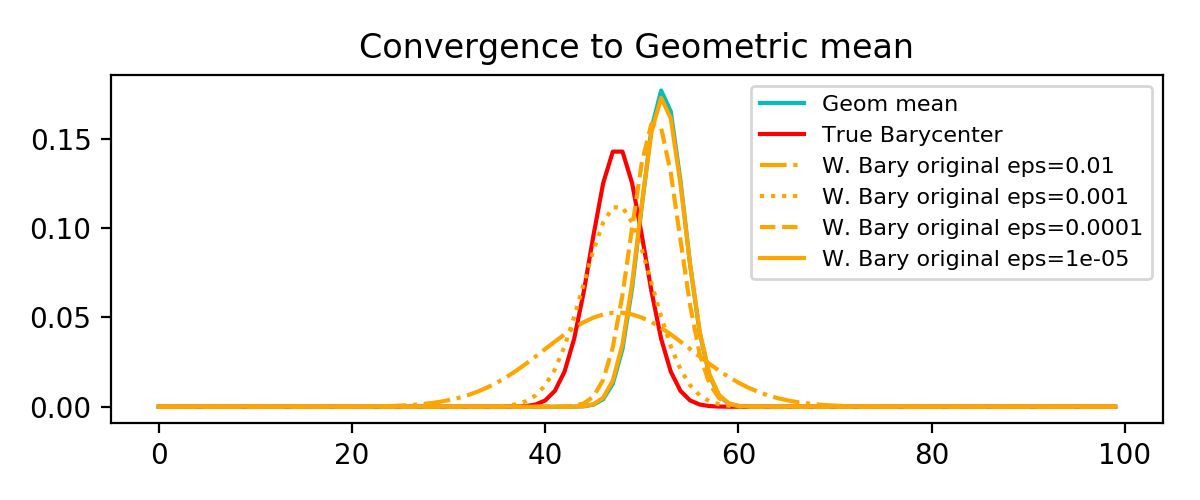

In [15]:
# Show that W. Barycenter converges to Geometric mean as epsilon converges to zero
epsilons = [1e-2, 1e-3, 1e-4, 1e-5]
lstyle = ['-.', ':', '--', '-']
qs = []    
for e in epsilons:
    q, _ = barycenter.compute(P=P, C=C, weights=w, stabilization='original', epsilon=e)
    q = q.cpu().numpy()
    q = q/np.sum(q)
    qs.append(q)

# -------------- Plotting -----------------

plt.figure(figsize=(6, 2.5))
plt.clf()
plt.plot(x, geom_mean, 'c', label='Geom mean')
plt.plot(x, true_gauss_bary, 'r', label='True Barycenter')

for q, e, ls in zip(qs, epsilons, lstyle):
    plt.plot(x, q, 'orange', label='W. Bary original eps=' + str(e), linestyle=ls)
plt.title('Convergence to Geometric mean')
plt.legend(prop={'size': 8})
plt.tight_layout()

# as we decrease down the epsilon to some value, the estimate keeps converging to the true Barycenter
# but once we decrease it pass that value, the estimate starts collapsing to a Geometric mean
# depending on stabilization options used ('orginal', 'log-domain', 'log-stabilized'), the threshold epsilon value changes